# Kaggle Competition (Data Mining)

**Emotion Recognition on Twitter**  
**Name: Huang Yu-Lin, Student ID: 108061539**

---
## 1. load data

In [1]:
import numpy as np
import pandas as pd
import json

data = []
for line in open('./data/tweets_DM.json', 'r'):
    data.append(json.loads(line))
    
data_df = pd.DataFrame.from_dict(data)

In [2]:
# check
data_df.head()

,_score,_index,_source,_crawldate,_type
0,391,hashtag_tweets,"{'tweet': {'hashtags': ['Snapchat'], 'tweet_id...",2015-05-23 11:42:47,tweets
1,433,hashtag_tweets,"{'tweet': {'hashtags': ['freepress', 'TrumpLeg...",2016-01-28 04:52:09,tweets
2,232,hashtag_tweets,"{'tweet': {'hashtags': ['bibleverse'], 'tweet_...",2017-12-25 04:39:20,tweets
3,376,hashtag_tweets,"{'tweet': {'hashtags': [], 'tweet_id': '0x1cd5...",2016-01-24 23:53:05,tweets
4,989,hashtag_tweets,"{'tweet': {'hashtags': [], 'tweet_id': '0x2de2...",2016-01-08 17:18:59,tweets


In [3]:
# add new columns: hashtags, tweet_id, text
text = []
for source in data_df['_source']:
    text.append([source['tweet']['tweet_id'], source['tweet']['text']])
text = np.array(text)

In [4]:
# sort by tweet_id
text = text[np.argsort(text[:,0])]
# check
text

array([['0x1c7f0f',
        "@JZED74 While inappropriate AF, he likely wasn't kidding.  <LH>"],
       ['0x1c7f10', 'o m g Shut Up And Dance though #BlackMirror <LH>'],
       ['0x1c7f11',
        'On #twitch <LH> on the #Destinybeta #Destiny #Destiny2 #DestinytheGame #Hunter #Titan #Warlock #Destiny2theGame #Beta #Destiny2Beta #PS4'],
       ...,
       ['0x38fe1b',
        "I told myself I'd be twitter famous. twitter machine <LH>"],
       ['0x38fe1c', '..today was brutal  ..#Hungover'],
       ['0x38fe1d',
        'Love it when I sun burn my forehead!! NOT!! 😫😱🙄🤦🏼\u200d♀️☀️ #redheadproblems <LH> #ouch #burnt']],
      dtype='<U252')

In [5]:
len(text)

1867535

In [6]:
# emotion label
label_emo = pd.read_csv('./label/emotion.csv', header=None).to_numpy()[1:]

In [7]:
# sort by tweet_id
label_emo = label_emo[np.argsort(label_emo[:,0])]
# check
label_emo

array([['0x1c7f10', 'joy'],
       ['0x1c7f11', 'anticipation'],
       ['0x1c7f14', 'joy'],
       ...,
       ['0x38fe1a', 'surprise'],
       ['0x38fe1c', 'disgust'],
       ['0x38fe1d', 'sadness']], dtype=object)

In [8]:
len(label_emo)

1455563

In [9]:
# identification label
label_id = pd.read_csv('./label/data_identification.csv', header=None).to_numpy()[1:]

In [10]:
# sort by tweet id
label_id = label_id[np.argsort(label_id[:,0])]
# check
label_id

array([['0x1c7f0f', 'test'],
       ['0x1c7f10', 'train'],
       ['0x1c7f11', 'train'],
       ...,
       ['0x38fe1b', 'test'],
       ['0x38fe1c', 'train'],
       ['0x38fe1d', 'train']], dtype=object)

In [11]:
len(label_id)

1867535

In [12]:
# train test split
train_idx = np.where(label_id[:,1] == 'train')
test_idx = np.where(label_id[:,1] == 'test')

In [13]:
train_data = text[train_idx].reshape(len(train_idx[0]), -1) # hashtag, text
test_data = text[test_idx].reshape(len(test_idx[0]), -1)
train_label = label_emo[:,1:].reshape(-1,)
# check shape
assert len(train_data) == len(train_label)
print(train_data.shape)
print(train_label.shape)
print(test_data.shape)

(1455563, 2)
(1455563,)
(411972, 2)


In [14]:
train_data_df = pd.DataFrame(train_data, columns =['tweet_id', 'text']) 
train_data_df.head()

,tweet_id,text
0,0x1c7f10,o m g Shut Up And Dance though #BlackMirror <LH>
1,0x1c7f11,On #twitch <LH> on the #Destinybeta #Destiny #...
2,0x1c7f14,A nice sunny wak this morning not many <LH> ar...
3,0x1c7f15,I'm one of those people who love candy corn......
4,0x1c7f16,@metmuseum What are these? They look like some...


In [15]:
test_data_df = pd.DataFrame(test_data, columns =['tweet_id', 'text']) 
test_data_df.head()

,tweet_id,text
0,0x1c7f0f,"@JZED74 While inappropriate AF, he likely wasn..."
1,0x1c7f12,I tried to figure out why you mean so much to ...
2,0x1c7f13,"The only “big plan” you ever had in your life,..."
3,0x1c7f17,"Looking back on situations old & new, recent o..."
4,0x1c7f18,@jasoninthehouse Why do you insist on talking ...


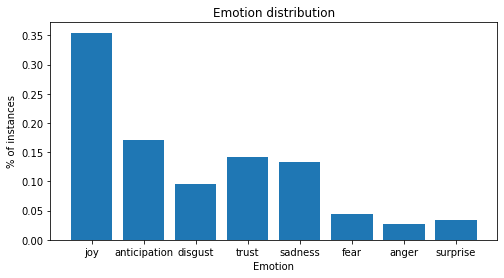

In [16]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# check class distribution
distribution = {}
for emo in train_label:
    if emo in distribution:
        distribution[emo] += 1
    else:
        distribution[emo] = 1
emo_lst = [key for key in distribution.keys()]
num_lst = np.array([distribution[emo] for emo in emo_lst])
num_lst = num_lst / sum(num_lst)

# plot
fig, ax = plt.subplots(figsize=(8,4))
plt.bar(emo_lst, num_lst)

#arrange
plt.ylabel('% of instances')
plt.xlabel('Emotion')
plt.title('Emotion distribution')
plt.show()

**We can find out that it's an unbalanced dataset. (8 categories)**

In [17]:
# encode label
from keras import utils
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(train_label)
train_label_encoded = label_encoder.transform(train_label)
# label encode (one hot)
y_train = utils.to_categorical(train_label_encoded)

Using TensorFlow backend.


In [18]:
train_label

array(['joy', 'anticipation', 'joy', ..., 'surprise', 'disgust',
       'sadness'], dtype=object)

In [19]:
train_label_encoded

array([4, 1, 4, ..., 6, 2, 5])

In [20]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

**Encode the label from string to numbers (Ex: 'joy' -> 4).  
  Then, turn into one hot for classification (Ex: 4 -> 0 0 0 0 1 0 0 0).**

---
## 2. feature engineering

In [21]:
# functions for text preprocessing
import string
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

def remove_punctuation(text):
    no_punct = "".join([c for c in text if c not in string.punctuation])
    return no_punct

def remove_stopwords(text):
    words = [w for w in text if w not in stopwords.words('english')]
    return words

def word_lemmatizer(text):
    lemmatizer = WordNetLemmatizer()
    lem_text = [lemmatizer.lemmatize(i) for i in text]
    return lem_text

def word_stemmer(text):
    stemmer = PorterStemmer()
    stem_text = " ".join([stemmer.stem(i) for i in text])
    return stem_text

In [22]:
# preprocess
def preprocess(sentence, save_stop_words=False):
    # remove punctuation
    print('remove punctuation')
    sentence = sentence.apply(lambda x: remove_punctuation(x))
    # tokenizer
    print('tokenize')
    tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')
    sentence = sentence.apply(lambda x: tokenizer.tokenize(x.lower()))
    # remove stop words
    if not save_stop_words:
        print('remove stop words')
        sentence = sentence.apply(lambda x: remove_stopwords(x))
    # lemmatizer
    print('lemmatize')
    sentence = sentence.apply(lambda x: word_lemmatizer(x))
    return sentence

**Preprocessing the text plays an important role in NLP.**    
  * **Procedure: remove punctuation -> tokenize -> (remove stop words) -> lemmatize**  
  *Since stop words might be useful in lstm model, I run two different preprocess procedure.(saving stop words or not)* 

In [23]:
# clean test data
train_data_df['text_clean'] = preprocess(train_data_df['text'], save_stop_words=False)
test_data_df['text_clean'] = preprocess(test_data_df['text'], save_stop_words=False)

remove punctuation
tokenize
remove stop words
lemmatize
remove punctuation
tokenize
remove stop words
lemmatize


In [24]:
# clean test data (save stop words)
train_data_df['text_clean_ws'] = preprocess(train_data_df['text'], save_stop_words=True)
test_data_df['text_clean_ws'] = preprocess(test_data_df['text'], save_stop_words=True)

remove punctuation
tokenize
lemmatize
remove punctuation
tokenize
lemmatize


In [25]:
# sentence length analysis
train_data_df['sentence_len'] = train_data_df['text_clean_ws'].apply(lambda x: len(x))
train_data_df['sentence_len'].describe()

count    1.455563e+06
mean     1.487073e+01
std      6.299944e+00
min      1.000000e+00
25%      1.000000e+01
50%      1.500000e+01
75%      2.000000e+01
max      4.300000e+01
Name: sentence_len, dtype: float64

In [26]:
test_data_df['sentence_len'] = test_data_df['text_clean_ws'].apply(lambda x: len(x))
test_data_df['sentence_len'].describe()

count    411972.000000
mean         17.800661
std           5.289889
min           3.000000
25%          14.000000
50%          18.000000
75%          22.000000
max          59.000000
Name: sentence_len, dtype: float64

In [27]:
# save preprocessed text data
train_data_df.to_pickle('./data/train.pkl')
test_data_df.to_pickle('./data/test.pkl')

In [28]:
train_data_df.head()

,tweet_id,text,text_clean,text_clean_ws,sentence_len
0,0x1c7f10,o m g Shut Up And Dance though #BlackMirror <LH>,"[g, shut, dance, though, blackmirror, lh]","[o, m, g, shut, up, and, dance, though, blackm...",10
1,0x1c7f11,On #twitch <LH> on the #Destinybeta #Destiny #...,"[twitch, lh, destinybeta, destiny, destiny2, d...","[on, twitch, lh, on, the, destinybeta, destiny...",16
2,0x1c7f14,A nice sunny wak this morning not many <LH> ar...,"[nice, sunny, wak, morning, many, lh, aroud, w...","[a, nice, sunny, wak, this, morning, not, many...",24
3,0x1c7f15,I'm one of those people who love candy corn......,"[im, one, people, love, candy, corn, lot, 😁😂, ...","[im, one, of, those, people, who, love, candy,...",18
4,0x1c7f16,@metmuseum What are these? They look like some...,"[metmuseum, look, like, something, toddler, ma...","[metmuseum, what, are, these, they, look, like...",17


In [29]:
test_data_df.head()

,tweet_id,text,text_clean,text_clean_ws,sentence_len
0,0x1c7f0f,"@JZED74 While inappropriate AF, he likely wasn...","[jzed74, inappropriate, af, likely, wasnt, kid...","[jzed74, while, inappropriate, af, he, likely,...",9
1,0x1c7f12,I tried to figure out why you mean so much to ...,"[tried, figure, mean, much, couldnt, think, si...","[i, tried, to, figure, out, why, you, mean, so...",28
2,0x1c7f13,"The only “big plan” you ever had in your life,...","[“big, plan, ”, ever, life, promote, turnbullm...","[the, only, “big, plan, ”, you, ever, had, in,...",19
3,0x1c7f17,"Looking back on situations old & new, recent o...","[looking, back, situation, old, new, recent, w...","[looking, back, on, situation, old, new, recen...",22
4,0x1c7f18,@jasoninthehouse Why do you insist on talking ...,"[jasoninthehouse, insist, talking, clinton, wh...","[jasoninthehouse, why, do, you, insist, on, ta...",24


In [ ]:
# load preprocessed text data
train_data_df = pd.read_pickle('./data/train.pkl')
test_data_df = pd.read_pickle('./data/test.pkl')

---
## 3. Methods

In [ ]:
# utils
from keras import optimizers
from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

def get_seqs(text, tokenizer, max_length=128):
    sequences = tokenizer.texts_to_sequences(text)
    padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')
    return padded_sequences

def train_tokenizer(X, max_num_words=20000):
    tokenizer = Tokenizer(num_words=max_num_words)
    tokenizer.fit_on_texts(X)
    word_index = tokenizer.word_index
    print('Found %s unique tokens.' % len(word_index))
    return tokenizer

def build_weight(y):
    y_int = np.argmax(y, axis=1)
    class_weights = compute_class_weight('balanced', np.unique(y_int), y_int)
    d_class_weights = dict(enumerate(class_weights))
    return d_class_weights

def train_model(model, X, y, setup):
    class_weight = build_weight(y)
    callbacks = [ModelCheckpoint(filepath='model_{}.h5'.format(setup['type']), 
                                 monitor='val_accuracy', 
                                 save_best_only=True)]
    optimizer = optimizers.Adam(lr=setup['lr'], clipvalue=1.0)
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    model.summary()
    model.fit(X, y, epochs=setup['epochs'], batch_size=setup['batch_size'], callbacks=callbacks,
              validation_split=0.1, class_weight=class_weight)
    return model

def show_result(y_true, y_pred):
    f1 = f1_score(y_true, y_pred, average='macro')
    cm = confusion_matrix(y_true, y_pred)
    print('mean f1 score: %.4f' % f1)
    print('confusion matrix:\n{}'.format(cm))
    return f1

def make_prediction(model, X_train, y_train, X_test, setup):
    # train model
    model = train_model(model, X_train, y_train, setup)
    # predict
    model.load_weights('model_{}.h5'.format(setup['type']))
    probs = model.predict(X_test, verbose=1)
    preds = np.argmax(probs, axis=1).reshape(-1,)
    # record
    return preds

def make_submission(tweet_id_lst, emotion_lst, model_type):
    assert len(tweet_id_lst) == len(emotion_lst)
    prediction_dict = {}
    for idx, tweet_id in enumerate(tweet_id_lst):
        prediction_dict[tweet_id] = emotion_lst[idx]
    # submission
    submission_df = pd.read_csv('./sampleSubmission.csv')
    # write
    assert len(tweet_id_lst) == len(submission_df['id'])
    for idx, tweet_id in enumerate(submission_df['id']):
        submission_df.iloc[idx]['emotion'] = prediction_dict[tweet_id]
    submission_df.to_csv("./submission_{}.csv".format(model_type), index=False)
    print('submission file is done')

In [ ]:
# cross validation to evaluate the method
from sklearn.model_selection import KFold

def cv_evaluate(X, y, setup, cv=5):
    # train
    kf = KFold(n_splits=cv)
    y_pred_lst, y_true_lst = [], []
    for idx, (train_idx, val_idx) in enumerate(kf.split(X, y)):
        print('Fold - {}'.format(idx+1))
        # split
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        # build model
        if setup['type'] == 'dnn':
            model = dnn(setup)
        elif setup['type'] == 'blstm_att':
            model = blstm_att(setup)
        else:
            raise Exception('Undefined structure')
        # train model & make prediction
        preds = make_prediction(model, X_train, y_train, X_test, setup)
        # record
        y_true = np.argmax(y_val, axis=1).reshape(-1,)
        y_true_lst.extend(y_true)
        y_pred_lst.extend(preds)
    # evaluate
    show_result(y_true_lst, y_pred_lst)

**To select the best model with best parameters setting, cross validation is a great method to evaluate the performance of different methods**

### Method 1. 
tfidf + dnn

In [ ]:
import keras
from keras import backend as K
from keras import initializers, regularizers
from keras.layers import *
from keras.models import Sequential

def dnn(setup):
    # parameter setting
    input_dim = setup['max_features']
    p = setup['dropout']
    weight_decay = setup['weight_decay']
    # define model
    model = Sequential()
    model.add(Dense(256, activation='relu',
                    kernel_initializer='orthogonal',
                    kernel_regularizer=regularizers.l2(weight_decay),
                    bias_regularizer=regularizers.l2(weight_decay),
                    input_shape=(input_dim,)
                    ))
    model.add(Dropout(rate=p))
    model.add(Dense(64, activation='relu',
                    kernel_initializer='orthogonal',
                    kernel_regularizer=regularizers.l2(weight_decay),
                    bias_regularizer=regularizers.l2(weight_decay)
                    ))
    model.add(Dropout(rate=p))
    model.add(Dense(8, activation='softmax',
                    kernel_initializer='orthogonal',
                    kernel_regularizer=regularizers.l2(weight_decay),
                    bias_regularizer=regularizers.l2(weight_decay)
                    ))
    return model

In [ ]:
# evaluate by cross validation
from sklearn.feature_extraction.text import TfidfVectorizer

# parameter setup
setup = {'max_features': 20000, 'dropout': 0.5, 'weight_decay': 1e-4, 
         'batch_size': 256, 'lr': 0.001, 'epochs': 10, 'type': 'dnn'}

# train vectorizer
vectorizer = TfidfVectorizer(max_features=setup['weight_decay'])
vectorizer.fit(train_data_df['text_clean'].apply(lambda x: ' '.join(x)))

# feature encode
X_train = vectorizer.transform(train_data_df['text_clean'].apply(lambda x: ' '.join(x)))

# cross validation
cv_evaluate(X_train, y_train, setup, cv=5)

In [ ]:
# train on whole dataset and make submission

# feature encode
X_test = vectorizer.transform(test_data_df['text_clean'].apply(lambda x: ' '.join(x)))

# train & predict
model = dnn(setup)
y_pred = make_prediction(model, X_train, y_train, X_test, setup)

# make submission
emotion_lst = label_encoder.inverse_transform(y_pred)
make_submission(test_data_df['tweet_id'], emotion_lst, setup['type'])

#### Method 2. 
word2vec + blstm + self attention

In [ ]:
# self attention layer
from keras import backend as K
from keras.engine.topology import Layer

class Self_Attention(Layer):

    def __init__(self, output_dim, att_head, **kwargs):
        self.output_dim = output_dim
        self.att_head = att_head
        super(Self_Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.vec_dim = int(self.output_dim*self.att_head)
        self.pro_kernel = self.add_weight(name='kernel_p',
                                        shape=(3, input_shape[2], self.vec_dim),
                                        initializer='orthogonal',
                                        trainable=True)
        self.out_kernel = self.add_weight(name='kernal_o',
                                        shape=(1, self.vec_dim, input_shape[2]),
                                        initializer='orthogonal',
                                        trainable=True)
        super(Self_Attention, self).build(input_shape)

    def call(self, x):
        # projection
        WQ = K.dot(x, self.pro_kernel[0])
        WK = K.dot(x, self.pro_kernel[1])
        WV = K.dot(x, self.pro_kernel[2])
        # attention score
        QK = K.batch_dot(WQ, K.permute_dimensions(WK, [0, 2, 1]))
        # scale
        QK = QK / (self.vec_dim**0.5)
        # softmax normalization
        QK = K.softmax(QK)
        # weighted vector 
        V = K.batch_dot(QK, WV)
        # project to output space
        Z = K.dot(V, self.out_kernel[0])
        return Z

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1], input_shape[2])

In [ ]:
import keras
from keras import backend as K
from keras import initializers, regularizers
from keras.layers import *
from keras.models import Sequential

# define structure
def blstm_att(setup):
    # parameter setting
    max_num_words = setup['max_num_words']
    max_length = setup['max_length']
    att_head = setup['att_head']
    p = setup['dropout']
    weight_decay = setup['weight_decay']
    
    # define model
    model = Sequential()
    # word embedding
    model.add(Embedding(max_num_words, 128, input_length=max_length))
    # blstm
    model.add(Bidirectional(LSTM(units=128, 
                                 return_sequences=True, 
                                 dropout=p, 
                                 recurrent_dropout=p, 
                                 kernel_initializer='orthogonal',
                                 kernel_regularizer=regularizers.l2(weight_decay),
                                 bias_regularizer=keras.regularizers.l2(weight_decay)
                                 )))
    # self attention
    model.add(Self_Attention(128, att_head))
    # average pooling
    model.add(GlobalAveragePooling1D())
    model.add(Dropout(rate=p))
    # dimension reduction
    model.add(Dense(256, activation='relu',
                    kernel_initializer='orthogonal',
                    kernel_regularizer=regularizers.l2(weight_decay),
                    bias_regularizer=regularizers.l2(weight_decay)
                    ))
    model.add(Dropout(rate=p))
    # classifier
    model.add(Dense(8, activation='softmax',
                    use_bias=False,
                    kernel_initializer='orthogonal',
                    kernel_regularizer=regularizers.l2(weight_decay),
                    bias_regularizer=regularizers.l2(weight_decay)
                    ))
    return model

In [ ]:
# evaluate by cross validation

# parameter setup
setup = {'max_num_words': 100000, 'max_length': 64, 'att_head': 4, 'dropout': 0.5, 'weight_decay': 1e-4,
         'batch_size': 128, 'lr': 0.001, 'epochs': 5, 'type': 'blstm'}

# train tokenizer
tokenizer = train_tokenizer(train_data_df['text_clean_ws'].apply(lambda x: ' '.join(x)), max_num_words)

# feature encode
X_train = get_seqs(train_data_df['text_clean_ws'].apply(lambda x: ' '.join(x)), tokenizer, max_length)

# cross validation
cv_evaluate(X_train, y_train, setup, cv=5)

In [ ]:
# train on whole dataset and make submission

# feature encode
X_test = get_seqs(test_data_df['text_clean_ws'].apply(lambda x: ' '.join(x)), tokenizer, max_length)

# train & predict
model = blstm_att(setup)
y_pred = make_prediction(model, X_train, y_train, X_test, setup)

# make submission
emotion_lst = label_encoder.inverse_transform(y_pred)
make_submission(test_data_df['tweet_id'], emotion_lst, setup['type'])